# CSCI 3022 Project Part 1
<figure>
  <IMG SRC="https://www.colorado.edu/cs/profiles/express/themes/cuspirit/logo.png" WIDTH=50 ALIGN="right">
</figure>
    Marcus Almanza

Overview:
With the popularity of Netflix's tv series Queen's Gambit, chess has become quite popular in the last year. With playing a game of chess one person loses and another wins, I want to determine the typical amount of turns needed to be taken, as well as seeing if there's a way to increase the chance of winning. (This would be categorized as regression) 

I was able to find data on approximately 20,000 chess game results at the following link https://www.kaggle.com/datasnaek/chess which this data was gathered from observing chess games on an online chess website call Lichess.

This dataset contains the following 16 variables: Game ID, Rated (T/F), Start Time, End Time, Number of Turns, Game Status, Winner, Time Increment, White Player ID, White Player Rating, Black Player ID, Black Player Rating, All Moves in Standard Chess Notation, Opening Eco, Opening Name, Opening Ply, White Player Rating, Black Player Rating. 

The following variables, I will not be looking at analyzing as they deal mostly with usernames/IDs in Lichess. They are the following (4 Signals): Game ID, Rated (T/F), White Player ID,  Black Player ID. I also won't be looking the following 3 signals that deal with the start time, end time, and time increment;.






In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
%matplotlib inline
import scipy.stats as stats
import seaborn as sns
# Set color map to have light blue background
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm

Part 1: 
For the first part of this project I want to see the approximate number of turns before a game is won. Since white is given the first move, I want to see if there is an advantage to this by seeing if white has a higher win rate. For this I will use the following signals: Number of Turns (number of turns until game is done), Winner (black or white win). 


In [2]:
#read csv file and remove unneeded data from data frame
df = pd.read_csv('games.csv', dtype='unicode')
df = df.drop(columns = ['id','rated','created_at','last_move_at','white_id','black_id', 'increment_code' ])

#change type so data is read as integer values and not objects
df["turns"] = df["turns"].astype(str).astype(int)
df["black_rating"] = df["black_rating"].astype(str).astype(int)
df["white_rating"] = df["white_rating"].astype(str).astype(int)

#make empty list that will contain turn count
turns = []

#append values from df turns to empty turns list
for x in range(len(df['turns'])):
    turns.append(int(df['turns'][x]))
    
turns_mean = np.mean(turns)
print("The average number of turns is:", turns_mean)

The average number of turns is: 60.46599860404826


(array([1.037e+03, 2.083e+03, 3.348e+03, 3.894e+03, 3.270e+03, 2.196e+03,
        1.511e+03, 1.070e+03, 7.560e+02, 4.160e+02, 2.470e+02, 1.220e+02,
        5.800e+01, 2.000e+01, 1.700e+01, 8.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00]),
 array([  1.  ,  14.92,  28.84,  42.76,  56.68,  70.6 ,  84.52,  98.44,
        112.36, 126.28, 140.2 , 154.12, 168.04, 181.96, 195.88, 209.8 ,
        223.72, 237.64, 251.56, 265.48, 279.4 , 293.32, 307.24, 321.16,
        335.08, 349.  ]),
 <BarContainer object of 25 artists>)

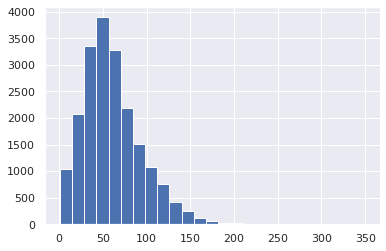

In [3]:
#plot a histogram of turn list
plt.hist(turns, bins = 25)

In [4]:
#Look and winner data from df
df.groupby(['winner']).describe()

turns                                                        \
          count       mean        std  min   25%   50%     75%    max   
winner                                                                  
black    9107.0  60.724388  32.369867  1.0  38.0  56.0   78.00  222.0   
draw      950.0  86.157895  45.897861  2.0  50.0  89.0  116.75  259.0   
white   10001.0  57.790221  32.193353  1.0  35.0  53.0   75.00  349.0   

       white_rating               ...                  black_rating  \
              count         mean  ...      75%     max        count   
winner                            ...                                 
black        9107.0  1549.246184  ...  1741.00  2621.0       9107.0   
draw          950.0  1655.558947  ...  1873.75  2524.0        950.0   
white       10001.0  1634.184182  ...  1822.00  2700.0      10001.0   

                                                                        
               mean         std    min     25%     50%     75%     max  
winner                                                                  
black   1638.227298  289.835927  789.0  1438.5  1609.0  1828.0  2621.0  
draw    1641.210526  303.839959  869.0  1445.5  1622.5  1837.0  2526.0  
white   1538.876712  282.227837  795.0  1343.0  1512.0  1728.0  2723.0  

[3 rows x 24 columns]

In [5]:
#Get a count of black, and white wins, and draws
black_win_count = 9107
white_win_count = 10001
draw_count = 950

total_count = black_win_count + white_win_count + draw_count

#Probability of white winning and probability of black winning
P_white_win = white_win_count/total_count
P_black_win = black_win_count/total_count

print("The probability of white winning is:", P_white_win)
print("The probability of black winning is:", P_black_win)


The probability of white winning is: 0.49860404826004584
The probability of black winning is: 0.45403330342008175


It can be seen that there is a higher chance of white winning, but I don't think the difference is high enough to truly determine if there is an advantage of playing as white. 

Part 2:

For this part I will use the below signals to clean up the data, and try to emphasize my point to see if there really is a much higher chance of white winning. I will also try to get a better number of turns to win count by getting rid of some of the outliers. 

    Game Status (how game ended mate, draw, time ran out, resign)
    Moves (All Moves in Standard Chess Notation)
    Opening Eco (Standardised Code for a given opening)
    Opening Name (Name of opening move)
    Opening Ply (Number of moves in the opening phase)

First, I'm going to take out the games that end in draws, resigns, and timeouts. I want to focus more on mates. The reason for this is because I want to look at official wins and losses. Since this data is from an online site, resigns and timeouts could be due to other reasons. For example mid game something important could've come up for someone where they had to resign even though they were in the lead.

I also think this will take out some of the outliers as well, there are some resigns that happen in only a couple moves. As well as some of the higher turn counts games that end in draws. 

In [6]:
#empty list these will be used as an index since dropping values doesn't resort index numbers in a database
#one list will have all games that end in mates, the other will be games that don't end in mates
non_mate = []
mate = []

#make the lists
for x in range(len(df['victory_status'])):
    if (df['victory_status'][x] != 'mate'):
        non_mate.append(x)
    else: 
        mate.append(x)

In [7]:
#drop non mates from the database
df_mate = df.drop(non_mate)

Now that the data has been cleaned a bit. Let's find what the average number of turns until a win. 

In [8]:
mate_turns = []

#append values from df turns to empty mate_turns list
for x in mate:
    mate_turns.append(int(df['turns'][x]))

#find the average
mate_turns_mean = np.mean(mate_turns)
print("The average number of turns is:", mate_turns_mean)

The average number of turns is: 65.41501976284584


Looks like the average win count is a little higher than before. This is likely due to the fact that there were a lot of resign games that happened without very many turns taking place. Let's see how the histogram looks now

(array([109., 229., 368., 547., 794., 878., 818., 530., 472., 339., 236.,
        247., 225., 155., 105.,  94.,  67.,  43.,  30.,  20.,   7.,   5.,
          3.,   3.,   1.]),
 array([  4.  ,  12.72,  21.44,  30.16,  38.88,  47.6 ,  56.32,  65.04,
         73.76,  82.48,  91.2 ,  99.92, 108.64, 117.36, 126.08, 134.8 ,
        143.52, 152.24, 160.96, 169.68, 178.4 , 187.12, 195.84, 204.56,
        213.28, 222.  ]),
 <BarContainer object of 25 artists>)

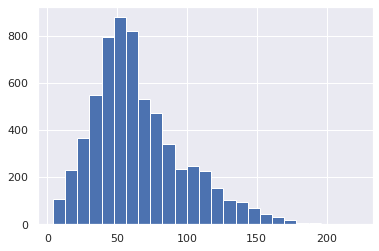

In [9]:
#histogram of turn count
plt.hist(mate_turns, bins = 25)

The distribution looks similar to the one before. Which makes sense since the average value is still close to the previous one. 

Now we'll look at white/black win probability

In [10]:
#Use below command to get a win count
df_mate.groupby(['winner']).describe()

turns                                                      \
         count       mean        std  min   25%   50%   75%    max   
winner                                                               
black   2981.0  67.257967  32.827057  4.0  44.0  60.0  84.0  222.0   
white   3344.0  63.772129  33.533667  5.0  40.5  57.0  81.0  193.0   

       white_rating               ...                 black_rating  \
              count         mean  ...     75%     max        count   
winner                            ...                                
black        2981.0  1476.468970  ...  1635.0  2336.0       2981.0   
white        3344.0  1576.497608  ...  1747.0  2621.0       3344.0   

                                                                         
               mean         std    min      25%     50%     75%     max  
winner                                                                   
black   1585.973499  274.879952  796.0  1392.00  1556.0  1761.0  2621.0  
white   1467.694079  261.260415  795.0  1290.75  1464.0  1621.0  2416.0  

[2 rows x 24 columns]

In [11]:
#Assign win count values
black_win_count = 2981
white_win_count = 3344
total_count = black_win_count + white_win_count

#Probability of white winning and probability of black winning
P_white_win = white_win_count/total_count
P_black_win = black_win_count/total_count

print("The probability of white winning is:", P_white_win)
print("The probability of black winning is:", P_black_win)

The probability of white winning is: 0.528695652173913
The probability of black winning is: 0.47130434782608693


Compared to before the probability of white winning is a little higher than it was before. I think it's enough to say that white has a slightly better chance of winning compared to black. 

Now, I'm going to do a little more cleaning to see if there's some opening moves that really give white an advantage over black. I will look at opening moves that have at least 30 games for that opening in the database

In [12]:
opening_name_u = [] #list that will contain unique opening name values
opening_name = [] #will contain all opening names for check mate
open_name_count30 = [] #will contain opening names that occurred more than 30 times in dataset

#makes list of unique opening move names
for x in df_mate['opening_name']:
    opening_name.append(x)
    if x not in opening_name_u:
        opening_name_u.append(x)
        
#make list of opening names with more than 30 data points       
for x in opening_name_u:
    if (opening_name.count(x) >= 30):
        open_name_count30.append(x)


Below code takes opening name and counts white/black wins and adds it to open_win_cnt list. It'll then make another list where white has a > .6 chance of winning with a particular opening move

In [13]:
#list for white/black win count and opening move name
open_win_cnt = [] 
for x in open_name_count30:
    w_win = 0
    b_win = 0
    
    for y in mate:
        if (x == df_mate['opening_name'][y]):
            if(df_mate['winner'][y] == 'white'):
                w_win = w_win +1
            else:
                b_win = b_win+1
    data = [x, w_win, b_win]
    open_win_cnt.append(data)
    
#list for win rate on open_win_cnt list
p = []
for x in open_win_cnt:
    p.append(x[1]/(x[1]+x[2]))

    
ww_60p = [] #list where white has > .6 chance of winning
ww_l60p = [] #list where white has <= .6 chance of winning
for x in range(len(p)):
    if (p[x] > .6):
        data60 = [open_win_cnt[x][0], p[x]]
        ww_60p.append(data60)
    else:
        data60 = [open_win_cnt[x][0], p[x]]
        ww_l60p.append(data60)

In [14]:
#sort list by highest win chance
ww_60p.sort(key=lambda x:x[1], reverse = True )
print(ww_60p)

[['Philidor Defense', 0.7708333333333334], ["King's Knight Opening", 0.7567567567567568], ["King's Pawn Game: Damiano Defense", 0.7272727272727273], ['Philidor Defense #3', 0.7164179104477612], ['Scotch Game', 0.7162162162162162], ['French Defense: Normal Variation', 0.7142857142857143], ["Bishop's Opening", 0.68], ["Queen's Gambit Refused: Marshall Defense", 0.6666666666666666], ["Queen's Pawn", 0.6585365853658537], ["Queen's Gambit Accepted: Old Variation", 0.65625], ["Queen's Pawn Game: Mason Attack", 0.65625], ['Four Knights Game: Italian Variation', 0.6461538461538462], ['Owen Defense', 0.6440677966101694], ['Scandinavian Defense: Mieses-Kotroc Variation', 0.6407766990291263], ['Italian Game', 0.6216216216216216], ['Italian Game: Anti-Fried Liver Defense', 0.6111111111111112], ['Ruy Lopez: Steinitz Defense', 0.6097560975609756]]


There's quite a few in the above list, so we'll just look at the top three moves that seem to give white quite a bit of a win advantage

In [15]:
for x in range(3):
    print('Opening move: '+ww_60p[x][0]+'; Probability of White Winning: '+str(ww_60p[x][1]))

Opening move: Philidor Defense; Probability of White Winning: 0.7708333333333334
Opening move: King's Knight Opening; Probability of White Winning: 0.7567567567567568
Opening move: King's Pawn Game: Damiano Defense; Probability of White Winning: 0.7272727272727273


Looking at the probabilities above, it seems if white is able to execute one of those three opening moves. There's a good chance of white winning. 77% chance of white winning using Philidor Defense. Or even looking at the list there's quite a bit where white has >60% chance of winning


Part 3

Now I want to see if there's any correlation with the number of turns, and player rating that affects white/black winning

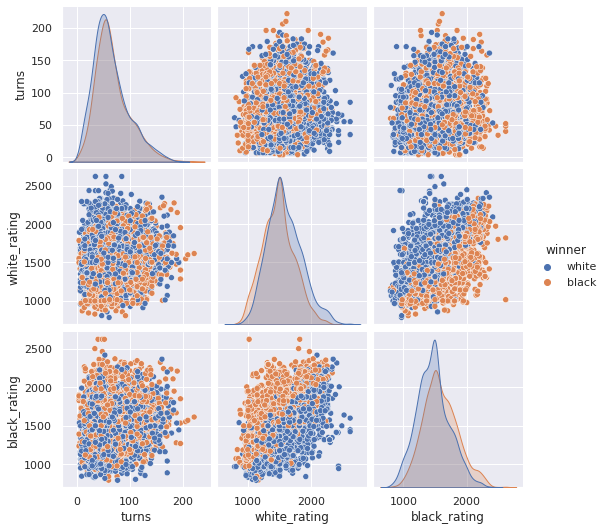

In [16]:
sns.pairplot(df_mate[['turns', 'white_rating', 'black_rating','winner']], hue='winner', diag_kind='kde');

I will use a couple multilinear models to try and expand a little on the above plot to see if there really is any relationship between the three variables.

We'll start by looking at correlation matrix. 

In [29]:
df_mate[['turns', 'white_rating', 'black_rating']].corr()

,turns,white_rating,black_rating
turns,1.000000,0.098123,0.139930
white_rating,0.098123,1.000000,0.529558
black_rating,0.139930,0.529558,1.000000


For the most part there doesn't look to be any correlation between the three. Just a slight correlation between white and black ratings that isn't that strong.

We'll try looking at some multi linear models with interaction terms to see if black or white rating can be predicted depending on the winner. 

In [17]:
#makes multilinear model with interaction to see if white rating can be predicted
model = smf.ols(formula='white_rating~black_rating*winner+turns', data=df_mate).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           white_rating   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     955.0
Date:                Sun, 02 May 2021   Prob (F-statistic):               0.00
Time:                        23:44:02   Log-Likelihood:                -42900.
No. Observations:                6325   AIC:                         8.581e+04
Df Residuals:                    6320   BIC:                         8.584e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      600.8276     23.327     25.757      0.000     555.100     646.556
winner[T.white]                 39.8264     31.199      1.277      0.202     -21.335     100.988
black_rating                     0.5421      0.014     38.042      0.000       0.514       0.570
black_rating:winner[T.white]     0.0853      0.020      4.242      0.000       0.046       0.125
turns                            0.2354      0.082      2.879      0.004       0.075       0.396
==============================================================================
Omnibus:                      375.194   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              921.311
Skew:                           0.354   Prob(JB):                    8.71e-201
Kurtosis:                       4.731   Cond. No.                     2.40e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
#makes multilinear model with interaction to see if black rating can be predicted
model = smf.ols(formula='black_rating~white_rating*winner+turns', data=df_mate).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           black_rating   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     998.0
Date:                Sun, 02 May 2021   Prob (F-statistic):               0.00
Time:                        23:44:02   Log-Likelihood:                -42933.
No. Observations:                6325   AIC:                         8.588e+04
Df Residuals:                    6320   BIC:                         8.591e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      626.7487     23.380     26.807      0.000     580.915     672.582
winner[T.white]                -81.5815     31.667     -2.576      0.010    -143.660     -19.503
white_rating                     0.6254      0.016     40.192      0.000       0.595       0.656
white_rating:winner[T.white]    -0.0618      0.021     -3.009      0.003      -0.102      -0.022
turns                            0.5339      0.082      6.519      0.000       0.373       0.694
==============================================================================
Omnibus:                      298.938   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              671.563
Skew:                           0.301   Prob(JB):                    1.49e-146
Kurtosis:                       4.478   Cond. No.                     2.49e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R^2 values aren't very good for both of those multi linear models. Had the model been better the first would indicate that if white wins it's a higher white rating, and second would indicate a higher black rating for black wins. 

Overall summarizing key points for this project.

    -The average number of turns for a chess game is about 65 turns
    -It seems like white does have a slightly higher chance of winning especially when certain opening moves are played
    -There is a slight indication, but not very good indication, of a higher white rating white wins and higher black
     rating black wins

If someone wanted to expand more on this. A classification regression could be used to predict winner. Or  looking at different regression models with beginning moves. Or seeing if a higher turn count gives an advantage to white or black.